In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from fastai.learner import DataLoaders
from fastai.vision.all import Learner
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.callback.progress import CSVLogger
from fastai.metrics import RocAuc
from fastai.optimizer import OptimWrapper
from functools import partial
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = "/Users/vav/Documents/TUD/Semester 3/LLM/Project/public_data/train/track_a/eng.csv"



class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

# Model definition
class BertEmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertEmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, x):
        input_ids, attention_mask = x
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        return self.fc(pooled_output)


/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/vav/miniconda3/envs/trdr/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.trans

In [2]:

# Load data
data = pd.read_csv(DATA_PATH)

# Prepare train and validation sets
train_data, valid_data = train_test_split(data, test_size=0.25, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

# Define model and training components
device = torch.device("mps")
model = BertEmotionClassifier(num_classes=5).to(device)
loss_func = nn.BCEWithLogitsLoss()



In [3]:

# FastAI DataLoaders
dls = DataLoaders(train_loader, valid_loader, device=device)
output_path = Path('base_model_2')
output_path.mkdir(exist_ok=True, parents=True)

# Define Learner
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[RocAuc()],
    path=output_path
)

# Callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_valid'),
    EarlyStoppingCallback(monitor='valid_loss', patience=9),
    CSVLogger()
]

In [ ]:

learn.fit_one_cycle(n_epoch=30, reset_opt=True, lr_max=1e-4, wd=1e-2, cbs=cbs)


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.589709,0.549483,0.639491,01:13
1,0.501014,0.453286,0.779910,01:06
2,0.408239,0.399772,0.805051,01:05
3,0.333453,0.389657,0.834651,01:06
4,0.238700,0.404615,0.816409,01:06
5,0.178667,0.443155,0.802966,01:06
6,0.118952,0.556277,0.796702,01:07
7,0.097749,0.598093,0.799785,01:06
8,0.064634,0.673365,0.782817,01:06
9,0.051339,0.705437,0.773368,01:06


Better model found at epoch 0 with valid_loss value: 0.5494830012321472.
Better model found at epoch 1 with valid_loss value: 0.4532855153083801.
Better model found at epoch 2 with valid_loss value: 0.3997718095779419.
Better model found at epoch 3 with valid_loss value: 0.3896573781967163.
No improvement since epoch 3: early stopping


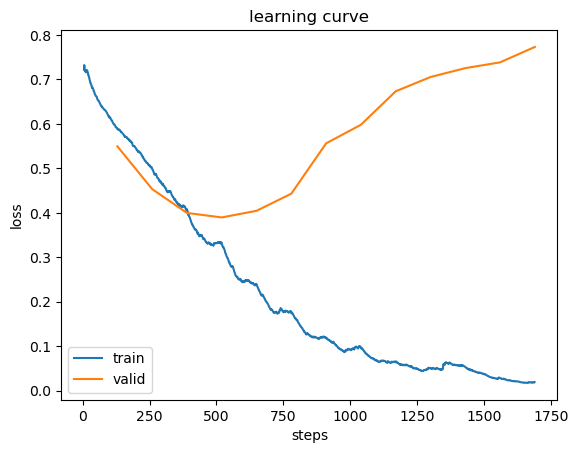

In [ ]:

learn.recorder.plot_loss()
plt.show()

In [ ]:
import pandas as pd

def predict_and_save_with_texts(learner, texts, output_csv):
    if learner.dls.valid is None:
        raise ValueError("The Learner does not have a validation DataLoader.")
    
    preds, targs = learner.get_preds(dl=learner.dls.valid)

    preds_binary = (preds > 0.5).int()

    results_df = pd.DataFrame({
        "Text": texts,
        "True Labels": [list(map(int, x)) for x in targs],
        "Predicted Labels": [list(map(int, x)) for x in preds_binary]
    })

    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return 


validation_texts = valid_data["text"].tolist()
predict_and_save_with_texts(learn, validation_texts, output_csv="results/validation_predictions_with_texts.csv")


Predictions saved to validation_predictions_with_texts_2.csv
